# MAM02 Regression and Prediction
Course: Fundamentals of data science for medicine \
Students: Dilara Tank, Martijn Siepel

The goal of this notebook is to analyze the association between 20 risk factors of Familial hypercholesterolemia (FH) on the one side and having yes/no a “CVD event” on the other side with an appropriate regression model.

The notebook will also explain our choices regarding the chosen regression models.

The dataset that is used for this study was collected by means of a cohort study among 2400 patients with FH. All were followed from birth onwards until age of CVD, or 31-december-2004 if CVD did not occur. The usual risk factors were determined and all data were entered in the SPSS-datafile ‘Girafh.sav’.

# Key points

* We start with a dataset with 20 possible risk factors for a CVD event (see [Table 1](#table1)).

* We process the data for univariate regression by converting all categorical data to numerical data. We process the data further for multivariate regression by imputing missing values using KNN, we split the data into a train and test set. 

* We look at the VIF to spot multicollinearity and drop 3 possible risk factors / predictors from the data (see [VIF](#vif)).

* We perform univariate regression to evaluate the association between the risk factors and CVD. We find that 'sex', 'hypertension' and 'diabetes' are good indicators of a CVD event in univariate regression because they have a high OR. We also find that 'HDL' has an insignificant pvalue and we exclude this from the dataset (see [Table 2](#table2)).

* We perform a bootstrapping method (Lasso) to exclude more variables from the training. 

* We train the prediction model on the train data, and test the model fit by predicting on the test data. We report accuracy, AUC, and a confusion matrix. Overall we conclude that our prediction model, which makes uses of the predictors 'sex', 'hypertension', 'Hba1c', 'Tg', 'Lpa', and 'homocysteine', provides an OK prediction for a CVD event (see [Outcome](#outcome)).

## Summarize the data

In [40]:
# imports
import pandas as pd
import numpy as np
from tableone import TableOne, load_dataset
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from fancyimpute import KNN 
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix

data_path = "GIRAFH.SAV"

### Data processing and exploration

The data has 21 rows (20 risk factors, and 1 outcome) and 2400 rows (total patients). In some columns, the data is numerical (example: bmi) and in some it is categorical (example: sex). 

In [2]:
original_data = pd.read_spss(data_path)
original_data

,sex,height,weight,bmi,alcoholuse,smoking,systbp,diasbp,hypertension,Glucose,...,diabetes,familiarHC,Tc,HDL,Tg,Lpa,homocysteine,creatinine,age,event
0,female,174.0,77.0,25.432686,no,Ever,140.0,95.0,yes,4.7,...,ever,yes,11.22,1.00,1.40,NaN,12.1,75.0,65.916496,none
1,male,179.0,65.0,20.286508,yes,Ever,140.0,95.0,no,4.5,...,ever,no,11.50,1.04,0.81,740.0,NaN,66.0,31.115674,yes
2,male,183.0,85.0,25.381469,yes,Ever,130.0,85.0,no,4.7,...,ever,no,11.36,1.64,1.67,NaN,NaN,79.0,47.791923,yes
3,female,169.0,63.0,22.058051,yes,Ever,130.0,75.0,no,4.6,...,ever,no,10.21,1.07,1.18,NaN,NaN,58.0,65.672827,none
4,male,176.0,88.0,28.409091,yes,Never,120.0,80.0,no,5.4,...,ever,no,10.09,1.69,1.01,NaN,NaN,63.0,42.318960,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,male,183.0,95.0,28.367524,yes,Ever,120.0,75.0,no,5.5,...,ever,yes,8.07,1.19,1.20,62.0,12.0,86.0,50.685832,none
2396,female,157.0,49.0,19.879103,no,Ever,95.0,60.0,no,4.7,...,ever,yes,NaN,NaN,NaN,88.0,10.0,53.0,24.079398,none
2397,female,163.0,70.0,26.346494,no,Never,130.0,80.0,no,4.5,...,ever,yes,NaN,NaN,NaN,159.0,9.0,65.0,47.236140,none
2398,female,160.0,64.0,25.000000,no,Never,135.0,80.0,no,4.4,...,ever,yes,8.50,1.80,1.10,63.0,8.0,57.0,50.562628,none


Let's show the data by summarizing it in a table. <a id='table1'></a>

In [3]:
categorical = original_data.select_dtypes(include=['object','category']).columns.tolist()
nonnormal = [x for x in original_data.columns if x not in categorical]

table = TableOne(data = original_data, categorical = categorical, nonnormal = nonnormal)
print(table.tabulate(tablefmt = "fancy_grid"))

╒══════════════════════════════╤════════╤═══════════╤═════════════════════╕
│                              │        │ Missing   │ Overall             │
╞══════════════════════════════╪════════╪═══════════╪═════════════════════╡
│ n                            │        │           │ 2400                │
├──────────────────────────────┼────────┼───────────┼─────────────────────┤
│ sex, n (%)                   │ female │ 0         │ 1220 (50.8)         │
├──────────────────────────────┼────────┼───────────┼─────────────────────┤
│                              │ male   │           │ 1180 (49.2)         │
├──────────────────────────────┼────────┼───────────┼─────────────────────┤
│ height, median [Q1,Q3]       │        │ 320       │ 172.0 [165.0,179.0] │
├──────────────────────────────┼────────┼───────────┼─────────────────────┤
│ weight, median [Q1,Q3]       │        │ 205       │ 74.0 [65.0,83.0]    │
├──────────────────────────────┼────────┼───────────┼─────────────────────┤
│ bmi, media

As we see from the table above, the collected data is not complete. The following code shows how many missing value are in each column.

In [4]:
original_data.isnull().sum()

sex                0
height           320
weight           205
bmi              342
alcoholuse       491
smoking          234
systbp            37
diasbp            37
hypertension      24
Glucose          118
Hba1c            930
diabetes           0
familiarHC         0
Tc               248
HDL              440
Tg               374
Lpa              702
homocysteine    1306
creatinine        71
age                0
event              0
dtype: int64

To impute the data for multivariate regression analysis, we first make it numerical. We use a modified code snippet from the blog [Preprocessing: Encode and KNN Impute All Categorical Features Fast](https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa).

In [5]:
# initialize the encoder
encoder = OrdinalEncoder()

def encode(data):
    '''function to encode non-null data and replace it in the original data, modified from the blog'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

# specify the categorical columns
cat_cols = original_data.select_dtypes(include=['object','category']).columns.tolist()

# make a placeholder
encoded_data = original_data.copy()

# iterate through each column in the data
for columns in cat_cols:
    if encoded_data[columns].dtype == 'category':
        encoded_data[columns] = encode(encoded_data[columns].astype(object))
    else:
        encoded_data[columns] = encode(encoded_data[columns].astype('category'))    
           
encoded_data

,sex,height,weight,bmi,alcoholuse,smoking,systbp,diasbp,hypertension,Glucose,...,diabetes,familiarHC,Tc,HDL,Tg,Lpa,homocysteine,creatinine,age,event
0,0.0,174.0,77.0,25.432686,0.0,0.0,140.0,95.0,1.0,4.7,...,0.0,1.0,11.22,1.00,1.40,NaN,12.1,75.0,65.916496,0.0
1,1.0,179.0,65.0,20.286508,1.0,0.0,140.0,95.0,0.0,4.5,...,0.0,0.0,11.50,1.04,0.81,740.0,NaN,66.0,31.115674,1.0
2,1.0,183.0,85.0,25.381469,1.0,0.0,130.0,85.0,0.0,4.7,...,0.0,0.0,11.36,1.64,1.67,NaN,NaN,79.0,47.791923,1.0
3,0.0,169.0,63.0,22.058051,1.0,0.0,130.0,75.0,0.0,4.6,...,0.0,0.0,10.21,1.07,1.18,NaN,NaN,58.0,65.672827,0.0
4,1.0,176.0,88.0,28.409091,1.0,1.0,120.0,80.0,0.0,5.4,...,0.0,0.0,10.09,1.69,1.01,NaN,NaN,63.0,42.318960,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1.0,183.0,95.0,28.367524,1.0,0.0,120.0,75.0,0.0,5.5,...,0.0,1.0,8.07,1.19,1.20,62.0,12.0,86.0,50.685832,0.0
2396,0.0,157.0,49.0,19.879103,0.0,0.0,95.0,60.0,0.0,4.7,...,0.0,1.0,NaN,NaN,NaN,88.0,10.0,53.0,24.079398,0.0
2397,0.0,163.0,70.0,26.346494,0.0,1.0,130.0,80.0,0.0,4.5,...,0.0,1.0,NaN,NaN,NaN,159.0,9.0,65.0,47.236140,0.0
2398,0.0,160.0,64.0,25.000000,0.0,1.0,135.0,80.0,0.0,4.4,...,0.0,1.0,8.50,1.80,1.10,63.0,8.0,57.0,50.562628,0.0


The data is now categorical. For univariate regression analysis, it is not needed to impute the missing data since it will only be used to look at an association between one variable and the outcome variable, so it's not dependent on other variables. 

We make a variable of the data that will be used for univariate regression analysis where the missing values will be disregarded per column.

In [6]:
univariate_data = encoded_data
univariate_data

,sex,height,weight,bmi,alcoholuse,smoking,systbp,diasbp,hypertension,Glucose,...,diabetes,familiarHC,Tc,HDL,Tg,Lpa,homocysteine,creatinine,age,event
0,0.0,174.0,77.0,25.432686,0.0,0.0,140.0,95.0,1.0,4.7,...,0.0,1.0,11.22,1.00,1.40,NaN,12.1,75.0,65.916496,0.0
1,1.0,179.0,65.0,20.286508,1.0,0.0,140.0,95.0,0.0,4.5,...,0.0,0.0,11.50,1.04,0.81,740.0,NaN,66.0,31.115674,1.0
2,1.0,183.0,85.0,25.381469,1.0,0.0,130.0,85.0,0.0,4.7,...,0.0,0.0,11.36,1.64,1.67,NaN,NaN,79.0,47.791923,1.0
3,0.0,169.0,63.0,22.058051,1.0,0.0,130.0,75.0,0.0,4.6,...,0.0,0.0,10.21,1.07,1.18,NaN,NaN,58.0,65.672827,0.0
4,1.0,176.0,88.0,28.409091,1.0,1.0,120.0,80.0,0.0,5.4,...,0.0,0.0,10.09,1.69,1.01,NaN,NaN,63.0,42.318960,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1.0,183.0,95.0,28.367524,1.0,0.0,120.0,75.0,0.0,5.5,...,0.0,1.0,8.07,1.19,1.20,62.0,12.0,86.0,50.685832,0.0
2396,0.0,157.0,49.0,19.879103,0.0,0.0,95.0,60.0,0.0,4.7,...,0.0,1.0,NaN,NaN,NaN,88.0,10.0,53.0,24.079398,0.0
2397,0.0,163.0,70.0,26.346494,0.0,1.0,130.0,80.0,0.0,4.5,...,0.0,1.0,NaN,NaN,NaN,159.0,9.0,65.0,47.236140,0.0
2398,0.0,160.0,64.0,25.000000,0.0,1.0,135.0,80.0,0.0,4.4,...,0.0,1.0,8.50,1.80,1.10,63.0,8.0,57.0,50.562628,0.0


We now impute the missing values for multivariate regression using fancyimpute's KNN, which utilizes k-Nearest Neighbors method to replace the missing value in the data with the mean value from the 'n' nearest neighbors found. By default, it uses a Euclidean distance metric to impute the missing values with 5 nearest neighbours.

We chose a KNN imputation method because we assume that a point value can be approximated by the values of the points that are closest to it, meaning that similar people have similar outcomes

In [7]:
# initialize the imputer
imputer = KNN()

# impute the data
df = encoded_data
imputed_df = pd.DataFrame(np.round(imputer.fit_transform(df)),columns = df.columns)

imputed_df

Imputing row 1/2400 with 1 missing, elapsed time: 1.074
Imputing row 101/2400 with 4 missing, elapsed time: 1.081
Imputing row 201/2400 with 1 missing, elapsed time: 1.085
Imputing row 301/2400 with 3 missing, elapsed time: 1.089
Imputing row 401/2400 with 1 missing, elapsed time: 1.093
Imputing row 501/2400 with 0 missing, elapsed time: 1.096
Imputing row 601/2400 with 3 missing, elapsed time: 1.100
Imputing row 701/2400 with 1 missing, elapsed time: 1.103
Imputing row 801/2400 with 1 missing, elapsed time: 1.106
Imputing row 901/2400 with 2 missing, elapsed time: 1.108
Imputing row 1001/2400 with 0 missing, elapsed time: 1.111
Imputing row 1101/2400 with 0 missing, elapsed time: 1.114
Imputing row 1201/2400 with 1 missing, elapsed time: 1.116
Imputing row 1301/2400 with 0 missing, elapsed time: 1.120
Imputing row 1401/2400 with 8 missing, elapsed time: 1.123
Imputing row 1501/2400 with 2 missing, elapsed time: 1.133
Imputing row 1601/2400 with 2 missing, elapsed time: 1.142
Imputing 

,sex,height,weight,bmi,alcoholuse,smoking,systbp,diasbp,hypertension,Glucose,...,diabetes,familiarHC,Tc,HDL,Tg,Lpa,homocysteine,creatinine,age,event
0,0.0,174.0,77.0,25.0,0.0,0.0,140.0,95.0,1.0,5.0,...,0.0,1.0,11.0,1.0,1.0,64.0,12.0,75.0,66.0,0.0
1,1.0,179.0,65.0,20.0,1.0,0.0,140.0,95.0,0.0,4.0,...,0.0,0.0,12.0,1.0,1.0,740.0,9.0,66.0,31.0,1.0
2,1.0,183.0,85.0,25.0,1.0,0.0,130.0,85.0,0.0,5.0,...,0.0,0.0,11.0,2.0,2.0,445.0,10.0,79.0,48.0,1.0
3,0.0,169.0,63.0,22.0,1.0,0.0,130.0,75.0,0.0,5.0,...,0.0,0.0,10.0,1.0,1.0,294.0,9.0,58.0,66.0,0.0
4,1.0,176.0,88.0,28.0,1.0,1.0,120.0,80.0,0.0,5.0,...,0.0,0.0,10.0,2.0,1.0,195.0,20.0,63.0,42.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1.0,183.0,95.0,28.0,1.0,0.0,120.0,75.0,0.0,6.0,...,0.0,1.0,8.0,1.0,1.0,62.0,12.0,86.0,51.0,0.0
2396,0.0,157.0,49.0,20.0,0.0,0.0,95.0,60.0,0.0,5.0,...,0.0,1.0,9.0,1.0,1.0,88.0,10.0,53.0,24.0,0.0
2397,0.0,163.0,70.0,26.0,0.0,1.0,130.0,80.0,0.0,4.0,...,0.0,1.0,8.0,1.0,3.0,159.0,9.0,65.0,47.0,0.0
2398,0.0,160.0,64.0,25.0,0.0,1.0,135.0,80.0,0.0,4.0,...,0.0,1.0,8.0,2.0,1.0,63.0,8.0,57.0,51.0,0.0


No missing values!

In [8]:
imputed_df.isnull().sum()

sex             0
height          0
weight          0
bmi             0
alcoholuse      0
smoking         0
systbp          0
diasbp          0
hypertension    0
Glucose         0
Hba1c           0
diabetes        0
familiarHC      0
Tc              0
HDL             0
Tg              0
Lpa             0
homocysteine    0
creatinine      0
age             0
event           0
dtype: int64

We will now look for multicollinearity in the data. Multicollinearity refers to the concept where several variables in the data are correlated. Because linear and logistic regression assume that features are indepenent of each other, it is good to check for this in your data. Using a dataset with multicollinearity will result in less reliable statistical inferences.  

There are multiple ways to check for multicollinearity, starting with a Correlation Matrix Heat map. In a correlation matrix, a value of 1 means that there is linearity between two variables. For exaple, all variables have a correlation of 1 with each other (the diagnoal). The more a correlation coefficient is away from 0, the more likely it is that two variables have a correlation. 

From the heatmap, for example, we see a correlation coefficient of 0.78 with the variables weight and bmi, meanign that weight and bmi are strongly correlated to each other. However, because a heatmap is not the best tool for when we have many features, we will also look at the Variance Influence Factor (VIF).

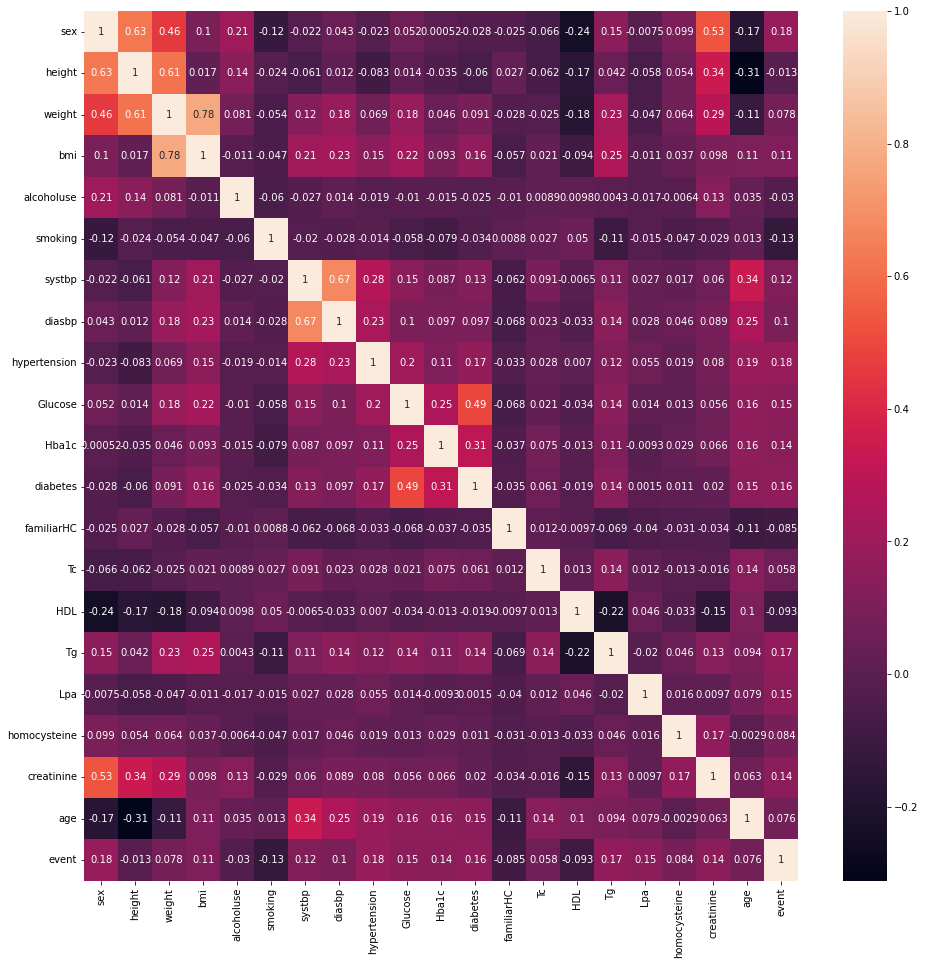

In [9]:
plt.rcParams["figure.figsize"] = (16,16)
corrMatrix = imputed_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Statsmodels'  [VIF](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) measures how much the variance of an 'independent' variable is influenced by its correlation with another variable and detects multicollinearity. Statsmodels advise the following: _if the VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this._


We calculate the VIF using a code snippet from the blog [Removing Multicollinearity for Linear and Logistic Regression](https://medium.com/analytics-vidhya/removing-multi-collinearity-for-linear-and-logistic-regression-f1fa744f3666 ).

<a id='vif'></a>

In [10]:
def get_VIF(dataFrame , target):
    X = add_constant(dataFrame.loc[:, dataFrame.columns != target])
    seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,)
    return seriesObject

target = 'Event'
print(get_VIF(imputed_df, target))

const           4363.055409
sex                2.266760
height            11.429830
weight            27.584146
bmi               17.201707
alcoholuse         1.071759
smoking            1.048592
systbp             2.016001
diasbp             1.908829
hypertension       1.168816
Glucose            1.422623
Hba1c              1.156908
diabetes           1.423614
familiarHC         1.026435
Tc                 1.058198
HDL                1.121762
Tg                 1.205583
Lpa                1.036321
homocysteine       1.037553
creatinine         1.495793
age                1.382705
event              1.189424
dtype: float64


In the VIF output for every column, we see that 'height', 'weight', and 'bmi' have a VIF value > 5. From the correlation matrix we already saw that weight and bmi were correlated to each other. Looking back at the correlation matrix, we see that height & weight also have a pretty high correlation (0.63), and height & bmi as well (0.61). 

To create a dataset without multicollinearity, we decided to drop these values since they could also be confounders for each other.

In [11]:
data = imputed_df.copy()
data.drop('bmi', axis=1, inplace=True)
data.drop('height', axis=1, inplace=True)
data.drop('weight', axis=1, inplace=True)

data

,sex,alcoholuse,smoking,systbp,diasbp,hypertension,Glucose,Hba1c,diabetes,familiarHC,Tc,HDL,Tg,Lpa,homocysteine,creatinine,age,event
0,0.0,0.0,0.0,140.0,95.0,1.0,5.0,6.0,0.0,1.0,11.0,1.0,1.0,64.0,12.0,75.0,66.0,0.0
1,1.0,1.0,0.0,140.0,95.0,0.0,4.0,5.0,0.0,0.0,12.0,1.0,1.0,740.0,9.0,66.0,31.0,1.0
2,1.0,1.0,0.0,130.0,85.0,0.0,5.0,5.0,0.0,0.0,11.0,2.0,2.0,445.0,10.0,79.0,48.0,1.0
3,0.0,1.0,0.0,130.0,75.0,0.0,5.0,6.0,0.0,0.0,10.0,1.0,1.0,294.0,9.0,58.0,66.0,0.0
4,1.0,1.0,1.0,120.0,80.0,0.0,5.0,6.0,0.0,0.0,10.0,2.0,1.0,195.0,20.0,63.0,42.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1.0,1.0,0.0,120.0,75.0,0.0,6.0,6.0,0.0,1.0,8.0,1.0,1.0,62.0,12.0,86.0,51.0,0.0
2396,0.0,0.0,0.0,95.0,60.0,0.0,5.0,4.0,0.0,1.0,9.0,1.0,1.0,88.0,10.0,53.0,24.0,0.0
2397,0.0,0.0,1.0,130.0,80.0,0.0,4.0,5.0,0.0,1.0,8.0,1.0,3.0,159.0,9.0,65.0,47.0,0.0
2398,0.0,0.0,1.0,135.0,80.0,0.0,4.0,6.0,0.0,1.0,8.0,2.0,1.0,63.0,8.0,57.0,51.0,0.0


We now have 3 column less than before. We check again voor multicollinearity, and see that the data is now good to go.

In [12]:
print(get_VIF(data, target))

const           179.397992
sex               1.658902
alcoholuse        1.070158
smoking           1.045915
systbp            2.010553
diasbp            1.887517
hypertension      1.164574
Glucose           1.396406
Hba1c             1.155780
diabetes          1.421184
familiarHC        1.025761
Tc                1.057205
HDL               1.120588
Tg                1.163504
Lpa               1.034708
homocysteine      1.037361
creatinine        1.484933
age               1.285434
event             1.169517
dtype: float64


To use the data for multivariate regression analysis. We split it in a train and test dataset.

In [13]:
X = data[data.columns]
y = data['event']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Evaluate the association between the risk factors and CVD 

To evaluate the association between the risk factors (the variables) and the CVD event, we will perform both univariable and multivariable association analysis. We start with univariate regression analysis.

We use the univariate data, drop all NaN values per column, and perform univariate regression using statsmodels' ```logit()``` function.

We use a logistic regression because the outcome variable is categorical. We can't use a linear regression model, because this assumes a linear relation between dependent and independent variables. This is not the case in our data, because the outcome variable is 'event' or 'no event'. The best option for us is to use logistic regression, since it is used to classify elements of a set into two groups (binary classification) by calculating the probability of each element of the set. In other words, for each risk factor the probability of event or no event is calculated and used for prediction.

<a id='table2'></a>

In [41]:
insignificant_dict = {}
high_OR_dict = {}

for risk_factor in data.columns[:-1]:
    # use the univariate data to drop all NaN values
    df = pd.DataFrame(pd.to_numeric(univariate_data[risk_factor])).join(pd.DataFrame(pd.to_numeric(univariate_data['event']))).dropna()
    print('length of the used dataframe:', len(df))
    
    # fit the univariate data
    SMF_model = smf.logit(formula='event~{}'.format(risk_factor), data=df).fit()
    print(SMF_model.summary())
    OR = np.exp(SMF_model.params)[1]
    print('OR {}:'.format(risk_factor), OR)
    print()
    
    # keep track of the interesting data
    p_value = SMF_model.pvalues[0]
    if p_value > 0.05:
        insignificant_dict[risk_factor] = p_value # insignificant p-values
    if OR > 2:
        high_OR_dict[risk_factor] = (OR) # high OR's

length of the used dataframe: 2400
Optimization terminated successfully.
         Current function value: 0.614451
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  event   No. Observations:                 2400
Model:                          Logit   Df Residuals:                     2398
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Oct 2022   Pseudo R-squ.:                 0.02652
Time:                        20:49:00   Log-Likelihood:                -1474.7
converged:                       True   LL-Null:                       -1514.9
Covariance Type:            nonrobust   LLR p-value:                 3.152e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1428      0.067    -17.091      0.000      -1.274      -

                           Logit Regression Results                           
Dep. Variable:                  event   No. Observations:                 2400
Model:                          Logit   Df Residuals:                     2398
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Oct 2022   Pseudo R-squ.:                0.005926
Time:                        20:49:00   Log-Likelihood:                -1505.9
converged:                       True   LL-Null:                       -1514.9
Covariance Type:            nonrobust   LLR p-value:                 2.263e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6352      0.048    -13.163      0.000      -0.730      -0.541
familiarHC    -0.4714      0.114     -4.139      0.000      -0.695      -0.248
OR familiarHC: 0.6241292390455248

length of the use

Now let's analyze some of these interesting results. We see that one variable has an insignificant p_value: HDL. We remove this variable from the dataset as well.

In [15]:
insignificant_dict

{'HDL': 0.5468713996414198}

In [16]:
data.drop('HDL', axis=1, inplace=True)

Furthermore, it seems that in univariate regression analysis, 'sex', 'hypertension' and 'diabetes' are good indicators of a CVD event because they have a high OR.

In [43]:
high_OR_dict

{'sex': 2.2035121187663598,
 'hypertension': 3.2918948878455976,
 'diabetes': 3.8462124418112635}

For further feature selection, we use a bootstrapping method called Lasso, using a code snippet from the blog [Feature Selection by Lasso](https://medium.com/@sabarirajan.kumarappan/feature-selection-by-lasso-and-ridge-regression-python-code-examples-1e8ab451b94b
). 

In [17]:
x = pd.DataFrame(data.drop(labels=["event"], axis=1))
y= pd.DataFrame(data["event"])

from sklearn.preprocessing import MinMaxScaler
Min_Max = MinMaxScaler()
X = Min_Max.fit_transform(x)
Y= Min_Max.fit_transform(y)

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2', solver='newton-cg'))
sel_.fit(X, np.ravel(Y,order='c'))
sel_.get_support()
X = pd.DataFrame(X)

selected_feat = X.columns[(sel_.get_support())]
print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)))

removed_feats = X.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats
data.columns[removed_feats]

total features: 16
selected features: 6
features with coefficients shrank to zero: 0


Index([], dtype='object')

The following 6 features are chosen by the lasso algorithm and will be used to train the multivariate regression model.

In [18]:
print(data.columns[selected_feat])

Index(['sex', 'hypertension', 'Hba1c', 'Tg', 'Lpa', 'homocysteine'], dtype='object')


## Make a prediction model for the presence of CVD

We train a multivariate logistic regression model on the ```train_data```.

In [19]:
# get independent variables
columns = data.columns[selected_feat]
# use the train split of the ata
X = X_train[data.columns[selected_feat]] 
# to get intercept 
X = sm.add_constant(X)
# get response variables
Y = data[['event']]
# fit the model with maximum likelihood functionS
model = sm.Logit(endog=y_train, exog=X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.573634
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  event   No. Observations:                 1608
Model:                          Logit   Df Residuals:                     1601
Method:                           MLE   Df Model:                            6
Date:                Fri, 14 Oct 2022   Pseudo R-squ.:                 0.09187
Time:                        19:53:41   Log-Likelihood:                -922.40
converged:                       True   LL-Null:                       -1015.7
Covariance Type:            nonrobust   LLR p-value:                 1.321e-37
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.8920      0.370    -10.529      0.000      -4.616      -3.168
sex              0.8401

In [21]:
np.exp(model.params)

const           0.020404
sex             2.316706
hypertension    2.707708
Hba1c           1.320018
Tg              1.223231
Lpa             1.000913
homocysteine    1.023486
dtype: float64

Above we plot the odds ratios (OR) of the trained multivariate model. The OR can be interpreted as the increase of odds of a CVD event (assuming all other independent variables constant). We see that sex is a big determant for a CVD event, and we see that for each unit increase in hypertension we expect that the odds for having a CVD event increases about 3 times.

We now make the predictions on the test data using the trained model.

In [22]:
# assemble the test data
X_test = sm.add_constant(X_test[data.columns[selected_feat]])
# make the predictions
pred = model.predict(exog=(X_test))

In [23]:
# print the confusion matrix and the accuracy
print('confusion matrix: \n', confusion_matrix(y_true=list(y_test), y_pred=list(round(pred))))
print()
print('accuracy:', accuracy_score(y_true=list(y_test), y_pred=list(round(pred))))

confusion matrix: 
 [[497  38]
 [177  80]]

accuracy: 0.7285353535353535


The diagonal numbers, 497 and 80, indicate the correct predictions (true negatives and true positives). The numbers 38 and 177 indicate the incorrect predictions (false positives and false negatives). All in all, there are more correct predictions than incorrect predictions. What's noteworthy is that there are also quite some false positives (177).

The accuracy of the prediction model is 0.73 (out of 1). This is overall a good score. 

To say more about the goodness of fit, we plot a ROC curve. In a ROC curve plot, the true positive rate and the false positive rate are plotted against each other. It shows how much a model is capable of distinguishing between classes. A higher area under the curve (AUC) means that the model is better at correctly distinguishing between classes.

We use a code snippet of [Bioinfokit](https://github.com/reneshbedre/bioinfokit/blob/master/bioinfokit/visuz.py) for nice visualizations. 

In [36]:
def roc(fpr=None, tpr=None, c_line_style='-', c_line_color='#f05f21', c_line_width=1, diag_line=True,
            diag_line_style='--', diag_line_width=1, diag_line_color='b', auc=None, shade_auc=False,
            shade_auc_color='#f48d60',
            axxlabel='False Positive Rate (1 - Specificity)', axylabel='True Positive Rate (Sensitivity)', ar=(0, 0),
            axtickfontsize=9, axtickfontname='Arial', axlabelfontsize=9, axlabelfontname='Arial',
            plotlegend=True, legendpos='lower right', legendanchor=None, legendcols=1, legendfontsize=8,
            legendlabelframe=False, legend_columnspacing=None, per_class=False, dim=(6, 5), show=False, figtype='png',
            figname='roc', r=300, ylm=None, theme=None):
        if theme == 'dark':
            general.dark_bg()
        plt.subplots(figsize=dim)
        # plt.margins(x=0)
        if auc:
            plt.plot(fpr, tpr, color=c_line_color, linestyle=c_line_style, linewidth=c_line_width,
                 label='AUC = %0.4f' % auc)
        else:
            plt.plot(fpr, tpr, color=c_line_color, linestyle=c_line_style, linewidth=c_line_width)
        if diag_line:
            plt.plot([0, 1], [0, 1], color=diag_line_color, linestyle=diag_line_style, linewidth=diag_line_width,
                     label='Chance level')
        if per_class:
            plt.plot([0, 0], [0, 1], color='grey', linestyle='-', linewidth=1)
            plt.plot([0, 1], [1, 1], color='grey', linestyle='-', linewidth=1, label='Perfect performance')
        # ylm must be tuple of start, end, interval
        if ylm:
            plt.ylim(bottom=ylm[0], top=ylm[1])
            plt.yticks(np.arange(ylm[0], ylm[1], ylm[2]), fontsize=axtickfontsize, fontname=axtickfontname)
        plt.yticks(fontsize=axtickfontsize, rotation=ar[1], fontname=axtickfontname)
        if axxlabel:
            _x = axxlabel
        if axylabel:
            _y = axylabel
        if shade_auc:
            plt.fill_between(x=fpr, y1=tpr, color=shade_auc_color)
        if plotlegend:
            plt.legend(loc=legendpos, bbox_to_anchor=legendanchor, ncol=legendcols, fontsize=legendfontsize,
                       frameon=legendlabelframe, columnspacing=legend_columnspacing)

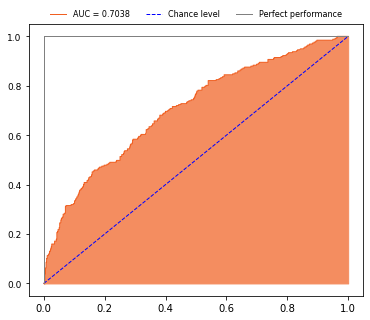

In [37]:
fpr, tpr, thresholds = roc_curve(y_true=list(y_test), y_score=list(pred))
auc = roc_auc_score(y_true=list(y_test), y_score=list(pred))
# plot ROC
roc(fpr=fpr, tpr=tpr, auc=auc, shade_auc=True, per_class=True, legendpos='upper center', legendanchor=(0.5, 1.08), legendcols=3)


In the plot, the grey lines indicate a perfect performance (a ROC of 1). The dotted line 'chance level' indicates the case that the model has no seperability capacity. In our case, the trained model has an AUC of 0.70, indicating an OK level of separability.

<a id='outcome'></a>